# A Jupyter notebook to demonstrate how to run your ML experiments in Code Ocean

This notebook assumes that you have created a source code for your ML models. If not, please check out the github repo [demoMLsourceCode](https://github.com/VirtualPatientEngine/demoMLsourceCode) to know how to write a source code for your ML models.

Once you have created a source code for your ML models, you can clone the repo and install the source code as a package in this capsule using the steps described in ```enviroment > postInstall```.

This notebook also assumes that you are familiar with the basics of Hydra and Lightning. Hydra allows you to define all the parameters in one place than hardwiring in your code. This helps you to keep your parameters separate from the code, keeping the code clean. Lightning provides an amazing template to get rid of the boilerplate code. It provides several functions that simply automate a lot of processes that you would have to otherwise manually perform or write in your code.

In this capsule, you can find the ```configs``` folder where I have defined parameters of all the models, data as well as trainer. You can also modify this folder based on the needs of your ML experiment. Anyway, we will import these configurations within the notebook as you will see below.

### Import the required libraries

In [1]:
import hydra
from omegaconf import DictConfig
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx
import random
import mlflow
import sys
import os
sys.path.append('..')

### Initialize the hydra object
The following cell initializes the hydra object by telling it that:
1. All the configs are stored in the folder <kbd>configs</kbd>.
2. Within the folder <kbd>configs</kbd>, it should look into the yaml file <kbd>config.yaml</kbd> for further instructions

The `cfg` object loads all the configurations provided in the default YML file. You can also override some of these configurations based on your needs. For this experiment, we are interested in using the GCN model so we explicitly specify in the snippet below to get the configurations of the model `gcn`. You can also set the `model_name` to ```mlp``` or any other ML you have defined.

In [73]:
# ML model you want to use
# e.g.: GCN or any other that you have defined in your source code
model_name = 'gcn'
# Initialize the hydra object and make it explicit to select the GCN
# since the YML file by default loads the MLP  model
with hydra.initialize(version_base=None, config_path="configs"):
    cfg = hydra.compose(config_name='config', overrides=[f'model={model_name}'])

###### MLflow set up
In the following cell, we create an MLflowClient to test whether an experiment with the same name exists or not, and notify the user.

In [77]:
experiment_name = 'Test'
run_name = 'gcn'
# Remote location of the S3 bucket (on AWS)
# You should have defined this as a custom key 
# in your environment
s3_bucket=os.environ['CUSTOM_KEY']
# Location to store the ML experiments locally
# This is also the location that you sync with the
# S3 bucket (see below)
tracking_uri = cfg.logger.tracking_uri
# Sync all contents from the S3 bucket (remote) to the local location
os.system(f"aws s3 sync {s3_bucket} {tracking_uri} --quiet")
# Let mlflow where you are storing your ML experiments
mlflow.set_tracking_uri(tracking_uri)
# If the expr_name is not already in use, create one
does_experiment_exist = mlflow.get_experiment_by_name(experiment_name)
if not does_experiment_exist:
    mlflow.create_experiment(experiment_name)
else:
    print (f'Experiment with name {experiment_name} exists. Loading it...')
# If the expr_name is already in use, use it to track
# your MLflow
mlflow.set_experiment(experiment_name)

Experiment with name Test exists. Loading it...


<Experiment: artifact_location='/tmp/mlflow/db/794067698698294328', creation_time=1714987543542, experiment_id='794067698698294328', last_update_time=1714987543542, lifecycle_stage='active', name='Test', tags={}>

###### Instantiate the source code

1. Within the app folder of the source code, we have defined 2 subfolders - model and data
2. While model contains the source for model-related modules (e.g.: MLP, GCN), data contains the source code to define the data-related modules (e.g.: CORA, MNIST).
3. The default parameters of their source code is defined in configs > model > *.yaml and configs > data > *.yaml
4. The yaml files also contain the path to the source code (check out the first line ```_target_```)
5. In the following cell, we instantiate the source code (in other words we initialize an object of the 2 classes and use the default parameters to initialize them)

In [78]:
# Initialize the model object
model_obj = hydra.utils.instantiate(cfg.model)

# Initialize the data object
cora_dataset = hydra.utils.instantiate(cfg.data)

###### Prepare/download data
Once you have intialized the datamodule, it's time to prepare the data (in other words download the data). Hence, we invoke the function prepare_data(). You can choose to define the prepare_data function based on your requirements. Please note that you don't have to call this function if you were to just do the ML because the trainer method below takes care of that by itself. But we call this function here since we want to visualize the graph.

In [79]:
cora_dataset.prepare_data()
graph = cora_dataset.data[0]

###### Visualize the graph
In this step, we visualize the graph by defining some functions that help us do so.

/tmp/ipykernel_91/2354778503.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, k=n_sample)


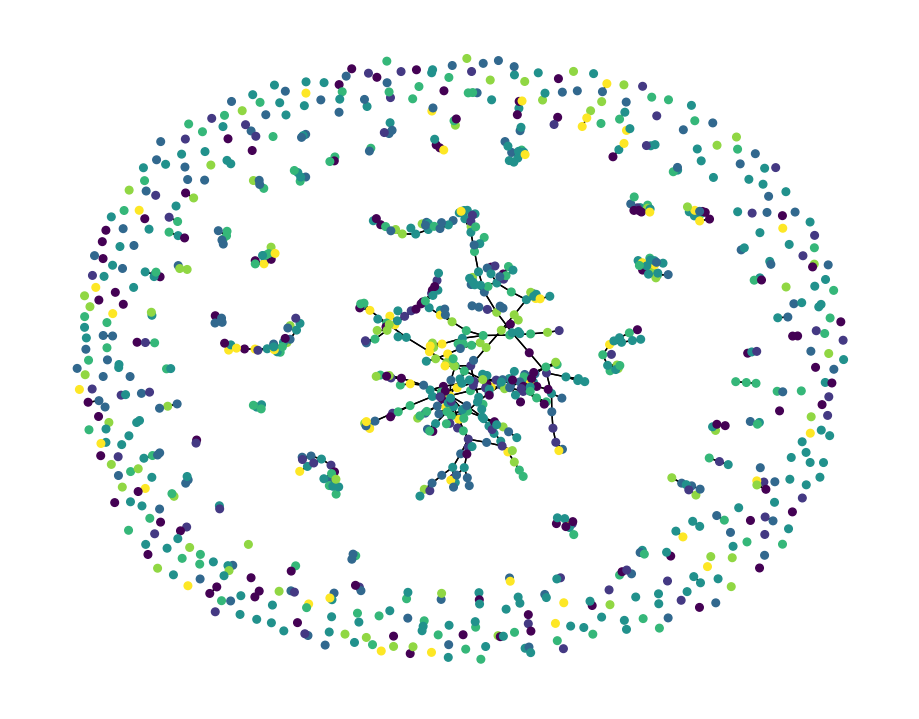

In [80]:
def convert_to_networkx(graph, n_sample=None):
    '''
    A method that takes in the graph and converts it
    into networkx format
    '''
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, k=n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    '''
    Plot tht networkx graph
    '''
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    # plt.show()
    plt.savefig("graph.png")

# conver the graph into nextworkx format
g, y = convert_to_networkx(graph, n_sample=1000)
# plot the graph in networkx format
plot_graph(g, y)

###### Initialize the trainer

Once we have initialized the model and data, and visualized the graph (optional), we will now initialize the trainer. Please note that for the trainer, we don't need to write source code. We can just directly use the code provided by lightning (check out ```_target_``` of configs > trainer > default.yaml). If you are unfamiliar with trainer, please checkout its description on lightning's website.

In [81]:
# Initialize the trainer
# trainer = hydra.utils.instantiate(cfg.trainer, logger=cfg.logger)
trainer = hydra.utils.instantiate(cfg.trainer, logger=None)
# Use the autolog method from mlflow to
# automatically log all the info during the run
mlflow.pytorch.autolog(
                        checkpoint_save_best_only=False,
                        registered_model_name='GCN',
                        log_every_n_epoch=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024/05/06 12:15:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


###### Fit the trainer using the model and data

In this step, we want to fit the trainer on the data using a given ML model. Please note that in case of the CORA dataset, pytorch library has already masked values of the data into ```train```, ```val```, and ```test```. We just need to inform the model about these masks. Check out the method ```model_step``` in the model source code (app/model/lit_mlp.py or lit_gcn.py).

Thus, we can provide same data to both train_loader and val_loader, and let the model source code figure out the split by itself.

In [82]:
with mlflow.start_run(run_name=run_name) as run:
    # perform training
    trainer.fit(model=model_obj, datamodule=cora_dataset)
    # get test_loss
    print (trainer.test(model=model_obj, datamodule=cora_dataset))


  | Name       | Type             | Params
------------------------------------------------
0 | conv1      | GCNConv          | 22.9 K
1 | conv2      | GCNConv          | 119   
2 | criterion  | CrossEntropyLoss | 0     
3 | train_loss | MeanMetric       | 0     
4 | val_loss   | MeanMetric       | 0     
5 | test_loss  | MeanMetric       | 0     
------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val loss: 1.9516575336456299


Training: |          | 0/? [00:00<?, ?it/s]

train loss: 1.9537473917007446


Validation: |          | 0/? [00:00<?, ?it/s]

val loss: 1.9393372535705566
train loss: 1.9468786716461182
train loss: 1.9401780366897583


Validation: |          | 0/? [00:00<?, ?it/s]

val loss: 1.9331663846969604
train loss: 1.9335790872573853


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train loss: 1.9270451068878174


2024/05/06 12:16:30 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-04-16; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'demomlsourcecode'}
Registered model 'GCN' already exists. Creating a new version of this model...
Created version '3' of model 'GCN'.


Testing: |          | 0/? [00:00<?, ?it/s]

test loss: 1.9223815202713013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9223815202713013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 1.9223815202713013}]


###### MLflow sync (IMPORTANT)
Once your ML experiment has ended, please sync your local copy with the S3 bucket.
Failure to do so will lead to loss of experiment logs

In [83]:
# Sync the local contents with the S3 bucket
os.system(f"aws s3 sync {tracking_uri} {s3_bucket} --quiet")

0

###### MLflow UI
To open the MLflow UI, please open the capsule MLflow Orchestration in another tab.

###### Load model for inference
Load the model from registry for inference

In [89]:
# Since the model is registered, simply specify the registered model name followed by
# the stage (None, staging, production, archived). We had not defined the stage yet, so
# choose None.
loaded_model = mlflow.pytorch.load_model(model_uri='models:/GCN/None')
# Provide the loaded model as well as datamodule to trainer, which will
# run the test. Remember, we don't have to specify the test set here, the model will
# figure that out by itself.
trainer.test(model=loaded_model, datamodule=cora_dataset)

Testing: |          | 0/? [00:00<?, ?it/s]

test loss: 1.9223815202713013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9223815202713013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9223815202713013}]